## Цель иследования
 - выявить частоту (периоды) повторяемости наблюдаемой характеристики 'rang_namber'
 - создать модель для ML позволяющую предиктить периоды на новых данных 
 - предположить факторы влияющие на чатсоту повторяемости
 - https://github.com/julianandrews/flopferret/blob/master/flopferret/board_texture.py

In [55]:
import re
import pandas as pd
from datetime import datetime
import eval7, pprint
from poker.room.pokerstars import PokerStarsHandHistory
from poker.hand import Hand, Combo
import numpy as np
from phevaluator import evaluate_cards
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [56]:
# Создали словарь
data_pd = {'TypeOfRoom': [], 'HandId': [], 'Tournament': [], 'Level': [], 'Date': [], 'Hour': [],
           'TimeZoneAbb': [], 'Table': [], 'NoOfPlayers': [], 'bain': [], 'HandHiro': [], 'Board': []}

# Открываем файл
with open('Poker_\SNG dimetruk 1-54133.txt', 'r') as f: #Poker_\SNG dimetruk 1-54133.txt
    data = f.read()
    
# Ищем нужные данные
result = re.findall('(\w+) Hand #(\d*): Tournament #(\d*),(.*) Level (.*) - (\d{4}/\d+/\d+) (\d+\D\d+\D\d+) (\w*)', data)
Tables = re.findall('Table \'.*\' (.*) Seat .*\n', data)
bains = re.findall('(\D\d+\.\d+\+\D\d+\.\d+)', data)
HandHiros = re.findall("Dealt to dimetruk \D(.. ..)\D", data)
Boards = re.findall("Board \[(.*)\]", data)


# Считаем сколко фишек
s = re.findall('Seat (\d).*chips', data)
s = [int(x) for x in s]
seats = []
length = 1
for i in range(len(s)-1):
    if s[i+1] < s[i]:
        seats.append(length)
        length = 1
    else:
        length += 1
seats.append(length)


# ЗАполнЯем словарь данными
for r, table, bain, seat, handHiro, board in zip(result, Tables, bains, seats, HandHiros, Boards):
    data_pd['TypeOfRoom'].append(r[0])
    data_pd['HandId'].append(r[1])
    data_pd['Tournament'].append(r[2])
    # data_pd['info'].append(r[3])
    data_pd['Level'].append(r[4])
    data_pd['Date'].append(r[5])
    data_pd['Hour'].append(r[6])
    data_pd['TimeZoneAbb'].append(r[7])
    data_pd['Table'].append(table) #table
    data_pd['NoOfPlayers'].append(seat)
    data_pd['bain'].append(bain)
    data_pd['HandHiro'].append(handHiro)
    data_pd['Board'].append(board)

# Создаём ДатаФрейм
d_f = pd.DataFrame(data_pd)
d_f.head()

,TypeOfRoom,HandId,Tournament,Level,Date,Hour,TimeZoneAbb,Table,NoOfPlayers,bain,HandHiro,Board
0,PokerStars,189303406555,2369603774,IV (40/80),2018/07/30,0:01:30,MSK,9-max,6,$13.70+$1.30,Qh 6h,8h 7d 2h 8c 4s
1,PokerStars,189303615886,2369603774,V (60/120),2018/07/30,0:05:40,MSK,9-max,6,$13.70+$1.30,Qc Td,Qh 5h Js Kd
2,PokerStars,189303670340,2369603774,V (60/120),2018/07/30,0:06:42,MSK,9-max,6,$13.70+$1.30,Ac 7d,2d Ad Ah Js 6s
3,PokerStars,189303726585,2369603774,V (60/120),2018/07/30,0:07:47,MSK,9-max,6,$13.70+$1.30,Tc Qc,Td 5h 2c 5d Kd
4,PokerStars,189303781865,2369603774,V (60/120),2018/07/30,0:08:51,MSK,9-max,6,$13.70+$1.30,Qs 5d,9s 7h Jh 8h 9d


## Преобразуем строковые данные

In [57]:
date = data_pd['Date']
time = data_pd['Hour']

d_f["Date"] = pd.to_datetime(data_pd['Date'])
d_f["Time"] = pd.to_timedelta(data_pd['Hour'])

d_f["DateTime"] = d_f["Date"] + d_f["Time"]
d_f["DateTime"]

d_f.Tournament = d_f.Tournament.astype('int64')
d_f = d_f.astype({'HandId': np.int64, 'Tournament': np.int64})

## Фильтруем данные

In [58]:
data_filter = d_f[['Tournament', 'HandId','DateTime', 'HandHiro', 'Board']]
data_filter.head()

,Tournament,HandId,DateTime,HandHiro,Board
0,2369603774,189303406555,2018-07-30 00:01:30,Qh 6h,8h 7d 2h 8c 4s
1,2369603774,189303615886,2018-07-30 00:05:40,Qc Td,Qh 5h Js Kd
2,2369603774,189303670340,2018-07-30 00:06:42,Ac 7d,2d Ad Ah Js 6s
3,2369603774,189303726585,2018-07-30 00:07:47,Tc Qc,Td 5h 2c 5d Kd
4,2369603774,189303781865,2018-07-30 00:08:51,Qs 5d,9s 7h Jh 8h 9d


In [59]:
#  Используйте group by и lambda для имитации фильтра для value_counts()  
# https://softhints.com/pandas-how-to-filter-results-of-value_counts/
df = data_filter.groupby('Tournament').filter(lambda x: len(x) > (data_filter['Tournament'].value_counts().mean())*2)
df

,Tournament,HandId,DateTime,HandHiro,Board
593,2376756155,189630702725,2018-08-07 22:22:20,4h 8c,7s 6h 7d 7h Qh
594,2376756155,189630765334,2018-08-07 22:23:52,Ac Td,Jh 7c 4s
595,2376756155,189630831791,2018-08-07 22:25:31,6s 9s,8d 8s 9d 7s 2h
596,2376756155,189630879488,2018-08-07 22:26:42,Ks 3s,2h Jh Jc
597,2376756155,189630930089,2018-08-07 22:27:56,2d Jc,Td Qs Ac 7h 7c
...,...,...,...,...,...
53755,2444273254,192791909601,2018-10-31 15:19:57,Js 3c,Ad Kd 8c
53756,2444273254,192791914785,2018-10-31 15:20:12,Kc 4d,3s 2d 6c 7h
53757,2444273254,192791925165,2018-10-31 15:20:40,8s 6c,Ks As Js
53758,2444273254,192791943877,2018-10-31 15:21:31,Ad 3s,5d 6h 9h 9d Jd


In [60]:
df.Tournament.value_counts().head()

2428056269    141
2428490625    123
2441088093    121
2437236305    116
2421274457    111
Name: Tournament, dtype: int64

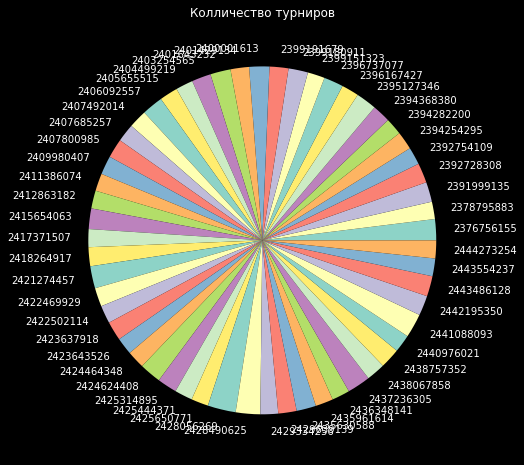

In [61]:
# Prepare Data
df_plot = df.groupby('Tournament').size()

# Make the plot with pandas
df_plot.plot(kind='pie', subplots=True, figsize=(8, 8))
plt.title("Колличество турниров")
plt.ylabel("")
plt.show()

In [62]:
# объеденяем руку и борд, выводим название комбинации

df['hand'] = df['HandHiro'] + " " + df['Board']
# hand = df['hand'].values[7].split()
# print(hand)

hand_ev = [eval7.Card(s) for s in (df['hand'].values[7].split())]
rang = eval7.evaluate(hand_ev)   # ранг комбинации
# print(rang)

eval7s = eval7.handtype(rang)  #  название комбинации

df['rang'] = eval7.evaluate(hand_ev)
df['eval7s'] =  eval7.handtype(rang)

In [63]:
df[['DateTime','hand', 'rang', 'eval7s']].head()  # применим фильтер по столбцам

,DateTime,hand,rang,eval7s
593,2018-08-07 22:22:20,4h 8c 7s 6h 7d 7h Qh,101462016,Full House
594,2018-08-07 22:23:52,Ac Td Jh 7c 4s,101462016,Full House
595,2018-08-07 22:25:31,6s 9s 8d 8s 9d 7s 2h,101462016,Full House
596,2018-08-07 22:26:42,Ks 3s 2h Jh Jc,101462016,Full House
597,2018-08-07 22:27:56,2d Jc Td Qs Ac 7h 7c,101462016,Full House


In [64]:
# def new_type(row):
#     if row.traffic_source.lower() in ('yandex', 'google'):
#         return 'organic'
#     elif row.traffic_source.lower() in ('paid', 'email'):
#         if row.region.lower() == 'russia':
#             return 'ad'
#         else:
#             return 'other'

In [65]:
# log['source_type'] = log.apply(new_type, axis = 1)
# log.head(12)

In [66]:
# log.loc[log.traffic_source.isin(['yandex', 'google']), 'traffic_type'] = 'organic' 

In [67]:
df['hand_rang'] = df['HandHiro'] + " " + df['Board']
df['hand_rang']

print(type(df['hand_rang']), type(df['hand_rang'].values[7].split()))
df['hand_rang'].values[0].split()

<class 'pandas.core.series.Series'> <class 'list'>


['4h', '8c', '7s', '6h', '7d', '7h', 'Qh']

In [68]:
# df['hand_rang'].to_list()
# df['hand_rang'].tolist()
# np.array(df['hand_rang'].tolist())
# Ls = list(df['hand_rang'])
ls = df['hand_rang'].str.split()
ls

593      [4h, 8c, 7s, 6h, 7d, 7h, Qh]
594              [Ac, Td, Jh, 7c, 4s]
595      [6s, 9s, 8d, 8s, 9d, 7s, 2h]
596              [Ks, 3s, 2h, Jh, Jc]
597      [2d, Jc, Td, Qs, Ac, 7h, 7c]
                     ...             
53755            [Js, 3c, Ad, Kd, 8c]
53756        [Kc, 4d, 3s, 2d, 6c, 7h]
53757            [8s, 6c, Ks, As, Js]
53758    [Ad, 3s, 5d, 6h, 9h, 9d, Jd]
53759    [Qs, 3c, 6s, 4c, Ah, Tc, 7d]
Name: hand_rang, Length: 5406, dtype: object

In [69]:
# напишем функцию получения ранг комбинации

def evaluate_(hand):
    """
    На вход получает карты, на выход 
    число ранг по eval7
    """
    hand_ev = [eval7.Card(s) for s in (hand)]
    return eval7.evaluate(hand_ev)

a = ('Jh', 'Td', '8h', '8c', '7c', '3h', '6d')
evaluate_(a)

17209424

In [70]:
# напишем функцию получения названия ранга

def handtype_(rang):
    """
    На вход получает ранг, на выход 
    название 
    """
    return eval7.handtype(rang)

handtype_(17209424)

'Pair'

In [71]:
# Применим функцию к столбцу hand  и запишем в новый столбец rang_namber

df['rang_namber'] = df['hand_rang'].str.split().apply(evaluate_)
df['handtypes'] = df['rang_namber'].apply(handtype_)
df[['rang_namber', 'handtypes']]
# df['filter'] = df.loc[df.handtypes.str.contains('Two Pair', 'Trips', 'Straight', 'Full House', 'Quads', 'Straight Flush'), 'rang_namber']

,rang_namber,handtypes
593,50701824,Trips
594,825426,High Card
595,34039040,Two Pair
596,17412352,Pair
597,17156752,Pair
...,...,...
53755,833889,High Card
53756,742433,High Card
53757,833892,High Card
53758,17287488,Pair


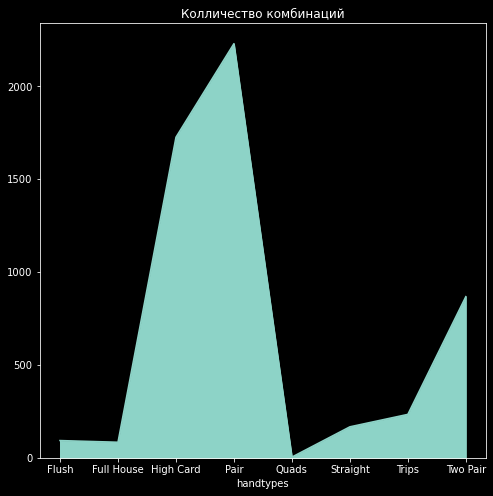

In [72]:
# Prepare Data
df_plot = df.groupby('handtypes').size()

# Make the plot with pandas
df_plot.plot(kind='area', subplots=True, figsize=(8, 8))
plt.title("Колличество комбинаций")
plt.ylabel("")
plt.show()

In [73]:
#df['DateTime'] = df['DateTime'][(df['DateTime'] > '2018-10-01 20:00:00') & (df['DateTime'] < '2018-10-02 00:00:00')]
df['DateTime']


593     2018-08-07 22:22:20
594     2018-08-07 22:23:52
595     2018-08-07 22:25:31
596     2018-08-07 22:26:42
597     2018-08-07 22:27:56
                ...        
53755   2018-10-31 15:19:57
53756   2018-10-31 15:20:12
53757   2018-10-31 15:20:40
53758   2018-10-31 15:21:31
53759   2018-10-31 15:22:47
Name: DateTime, Length: 5406, dtype: datetime64[ns]

In [74]:
# отфильтруем комбинации "старшая карта" и "пара"
df['filter'] = df['rang_namber'][df['rang_namber'] > 50000000] #[((df['rang_namber'] > 50000000) & (df['rang_namber'] < 60000000))]
df = df.dropna()
df[['filter','handtypes','HandHiro','Board']].head(50)
# df['filter_Two Pair'] = df['handtypes'][df['handtypes'] == 'Two Pair']
# df['filter_Two Pair']

,filter,handtypes,HandHiro,Board
593,50701824.0,Trips,4h 8c,7s 6h 7d 7h Qh
600,101462016.0,Full House,5c Ah,Qd 8h As Ad 5s
601,67895296.0,Straight,Th Jd,2d Ac Kd Qd 2h
619,101130240.0,Full House,9h 4c,4d 9c 9s 6c
633,50492672.0,Trips,4s 4d,7d 9c 2c 4c
639,67502080.0,Straight,8c 6d,4d 5d 7d 6h
642,50973184.0,Trips,2d Jh,As Jd Js Qd 7c
650,101122048.0,Full House,9h 2c,3d 8s 2h 9c 9d
651,67567616.0,Straight,7d 5s,8c 5d 6h 9c 3d
657,50775296.0,Trips,6d Ad,7s 8d 8c 8s


In [75]:
data = df[['DateTime', 'filter']]
data.head()

,DateTime,filter
593,2018-08-07 22:22:20,50701824.0
600,2018-08-07 22:30:28,101462016.0
601,2018-08-07 22:31:51,67895296.0
619,2018-08-07 22:50:10,101130240.0
633,2018-08-07 23:09:42,50492672.0


In [76]:
data.isnull().sum()

DateTime    0
filter      0
dtype: int64

In [77]:
# преобразуем время во временной ряд


In [78]:


idx = df['DateTime']
 # datetime.timedelta(seconds=24*60*60).total_seconds()

# second = df['DateTime'].dt.total_seconds()
# second

# idx = pd.date_range(df['DateTime'], periods=5, freq="H")
# idx
tim = pd.Series(range(len(idx)), index=idx)

# ts.resample("2H").mean()
tim 

DateTime
2018-08-07 22:22:20      0
2018-08-07 22:30:28      1
2018-08-07 22:31:51      2
2018-08-07 22:50:10      3
2018-08-07 23:09:42      4
                      ... 
2018-10-31 14:43:01    577
2018-10-31 14:50:16    578
2018-10-31 15:00:30    579
2018-10-31 15:04:40    580
2018-10-31 15:06:12    581
Length: 582, dtype: int64

In [79]:
# # # idx = pd.date_range('2019-01-01', periods=48, freq='H')
# # x = pd.Series(range(len(idx)), index=idx)
# y = tim
# # add 'hour' and 'day' columns in the dataframe
# d = {'x': x, 'y': y, 'hour': idx.hour, 'day': idx.day}
# df = pd.DataFrame(data=d)
# # use 'hour' as x axis to plot, and 'day' as marker color
# df.plot.scatter(x='hour', y='y', c='day', colormap='rainbow')
# plt.show()

In [80]:
data.dtypes

DateTime    datetime64[ns]
filter             float64
dtype: object

In [81]:
# установить datetime Объект в качестве индекса кадра данных
data = data.set_index('DateTime')
data.head(20)

,filter
DateTime,
2018-08-07 22:22:20,50701824.0
2018-08-07 22:30:28,101462016.0
2018-08-07 22:31:51,67895296.0
2018-08-07 22:50:10,101130240.0
2018-08-07 23:09:42,50492672.0
2018-08-07 23:13:22,67502080.0
2018-08-07 23:15:44,50973184.0
2018-08-07 23:19:35,101122048.0
2018-08-07 23:19:54,67567616.0


<AxesSubplot:xlabel='DateTime'>

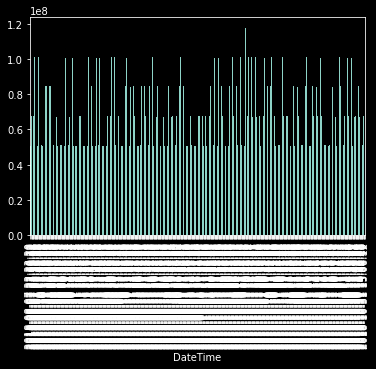

In [82]:

# data.plot(grid=True)

data['filter'].plot(kind='bar')

# import matplotlib.pyplot as plt
# from matplotlib.dates import DateFormatter
# # Группировка за месяц
# df_month = data.resample("M").mean()

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
# ax.bar(
#     df_month['2018':].index, 
#     df_month.loc['2016':, "filter"], 
#     width=25, align='center')

In [85]:
from pandas import Series
from matplotlib import pyplot
series = df
series.plot(style='k.')
pyplot.show()


OverflowError: int too big to convert

<Figure size 432x288 with 1 Axes>